# A Quantum Walk

$\textit{Group 1: Emil, Robin, Ege, Filippo, Netta \& Oxana}$

N.B.: Using Qiskit 1.2.4

Performing a quantum random walk in Hilbert space:

$\mathcal{H} = \mathcal{H_c} \otimes \mathcal{H_p}$

In [ ]:
#imports 
import numpy as np
import qiskit as q
import matplotlib.pyplot as plt

from qiskit.circuit.library.standard_gates import XGate, HGate
#from qiskit_ibm_runtime import QiskitRuntimeService #, Sampler
from qiskit.primitives import StatevectorSampler
#from qiskit_aer import AerSimulator
#from qiskit_aer.primitives import Sampler
from qiskit.quantum_info.operators import Operator
#from utils import *
from copy import deepcopy

## Walk on a line

For this example, we are going to perform a walk on the line and test, if we get the expected distributions related to the coin operators and initial coin states.

For this particular case, we are going to use the following parameters:

 - Number of position space qubits: $N_p = 7$
 - Number of coin space qubits: $N_c = 1$
 - Number of steps for each sample: $T = 50$
 - Number of samples: $n = 1024$

In [15]:
"""params:"""
Np = 7
Nc = 1
T = 50
n = 1024       
     
it_Np = range(Np)
it_n = range(n)
it_T = range(T)

"""init:"""
#service = QiskitRuntimeService()
#sim = AerSimulator.from_backend(service.least_busy(min_num_qubits=Np+Nc))

qreg = q.QuantumRegister(Np+Nc)
creg_pos = q.ClassicalRegister(Np, "position")
creg_coin = q.ClassicalRegister(Nc, "coin")
qc = q.QuantumCircuit(qreg, creg_pos, creg_coin) #number of qbits and number of cbits (to store position information in and finally coin (all qbits must be measured when using primitives))


In [16]:
""" Sampling from IBMQ:"""

#sampler = Sampler(service.least_busy(operational=True))

""" Sampling with Statevector Simulator:"""

sampler = StatevectorSampler()

### Operators:

Coins:

$H = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & 1 \\ 1 & -1 \end{pmatrix}$, $X = \begin{pmatrix} 0 & 1 \\ 1 & 0 \end{pmatrix}$ and $C_Y = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & i \\ i & 1 \end{pmatrix}$

Forward step operator:

$S_F = \sum_{j=0}^{127} \ket{j+1}\bra{j}$

Important note: Qiskit has opposite bit-ordering!

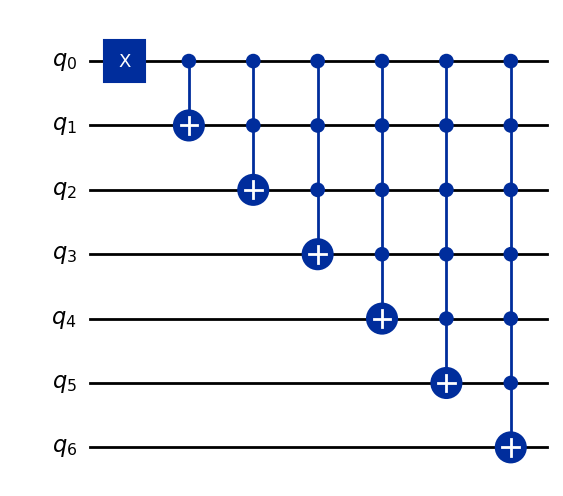

In [17]:
S_F = q.QuantumCircuit(Np)

for i in it_Np:
    current_qbit = Np-1-i
    if current_qbit == 0:
        g = XGate()
    else:
        g = XGate().control(num_ctrl_qubits=current_qbit)
    S_F.append(g, S_F.qregs[0][0:current_qbit+1])

#we need to invert:
S_F = S_F.inverse()

S_F.draw("mpl")

Backward step operator:

$S_B = S_F^\dagger$

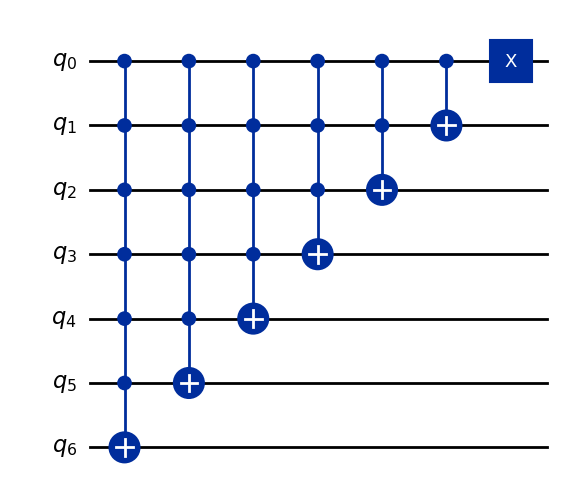

In [18]:
S_B = S_F.inverse()
S_B.draw("mpl")

The complete step operator:

$S = \ket{0}\bra{0}_c \otimes S_F + \ket{1}\bra{1}_c \otimes S_B$

We can now assemble the full Propagation operator:

$U = S \cdot (C \otimes \mathbb{1}_p)$

In [19]:
S_Fgate = S_F.to_gate().control(1)
S_Bgate = S_B.to_gate().control(1)

def propagator(num_qbits : int, coin_operator : q.circuit.Gate) -> q.circuit.Instruction:
    
    #The final building block: the propagate operator:
    U = q.QuantumCircuit(num_qbits)

    #Coin flip:
    U.append(coin_operator, U.qregs[0][0:1])

    #Controlled step forwards:
    U.append(S_Fgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    #Controlled step backwards:
    U.append(S_Bgate, U.qregs[0])

    #Negate coin:
    U.append(XGate(), U.qregs[0][0:1])

    return U.to_instruction()

## Running the walk:

In [ ]:
def perform_walk(qc : q.QuantumCircuit,
                 coin_operator : q.circuit.Gate,
                 coin_state : list[complex], position_state : dict[int],
                 creg_coin : q.ClassicalRegister, creg_pos : q.ClassicalRegister,
                 H_input = False) -> None:
    
    U = propagator(Np+Nc, coin_operator)

    all_qbits = qc.qregs[0]
    position_qbits = qc.qregs[0][1:Np+1]

    #initialize states:
    qc.initialize(coin_state, 0)
    for key in position_state:
        if position_state[key] == 1:
            qc.x(key)
        
    #If instructed, Hadamard the input
    if H_input:
        qc.h(position_qbits)

    for t in it_T:
        #propagate
        qc.append(U, all_qbits)

    #measure (statevecsim requires measurement at end):
    qc.measure(position_qbits, creg_pos) #TODO: Need better way to address certain qubits
    qc.measure(0, creg_coin)

In [ ]:
def do_run(coin_operator : q.circuit.Gate, coin_inputs : dict[complex], position_inputs : dict[int], start : int, showfig : bool = True) -> tuple[plt.Figure, plt.Axes]:
    pubs = []

    for input in coin_inputs:
        qc_instance = deepcopy(qc)
        perform_walk(qc_instance, coin_operator, coin_inputs[input], position_state=position_inputs, creg_coin=creg_coin, creg_pos=creg_pos)
        pubs.append((qc_instance))

    job = sampler.run(pubs, shots=n)
    result = job.result() 
    n_res = len(result)
    fig, ax = plt.subplots(ncols=n_res)
    fig.set_size_inches(4*n_res, 5)

    for i in range(n_res):
        posdata = result[i].data.position.array
        recentered_result = np.array(posdata, dtype=int).flatten() - start #recenter around 0
        ax[i].hist(recentered_result, histtype="step")
        ax[i].set_title(list(coin_inputs.keys())[i])

    if showfig:
        plt.show()

    return fig, ax

### H coin

First, let's try the Hadamard coin with the following input states: ${\ket{0}, \ket{1}, \ket{+i}}$

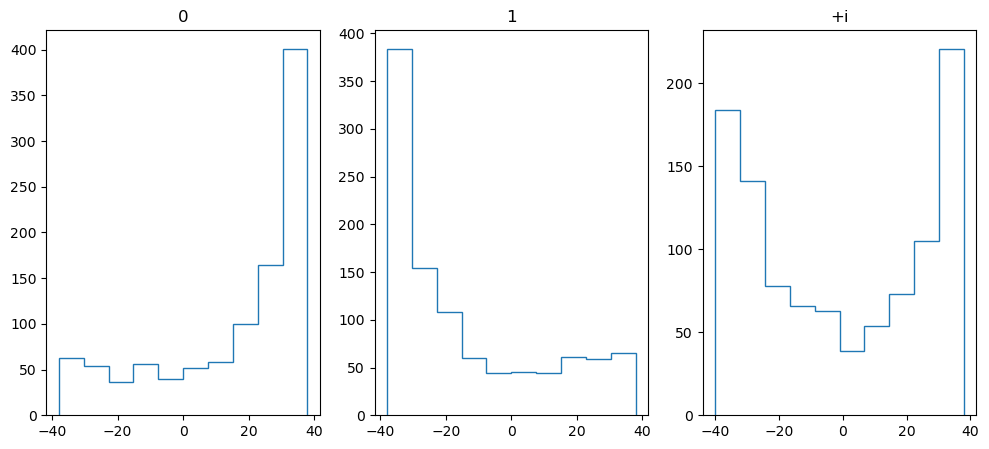

(<Figure size 1200x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '+i'}>], dtype=object))

In [22]:
coin_operator = HGate()

#initial position
#position_state = 63 is 0111111 in binary. NOTE: Qiskit has opposite MSB-LSB
start = 63
position_inputs = {
    1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 0
}

coin_inputs = {
    "0": [1., 0.],
    "1": [0., 1.],
    "+i": [1/np.sqrt(2), 1j/np.sqrt(2)]
}

standard_args = coin_inputs, position_inputs, start

do_run(coin_operator, *standard_args)

### X coin

same inputs

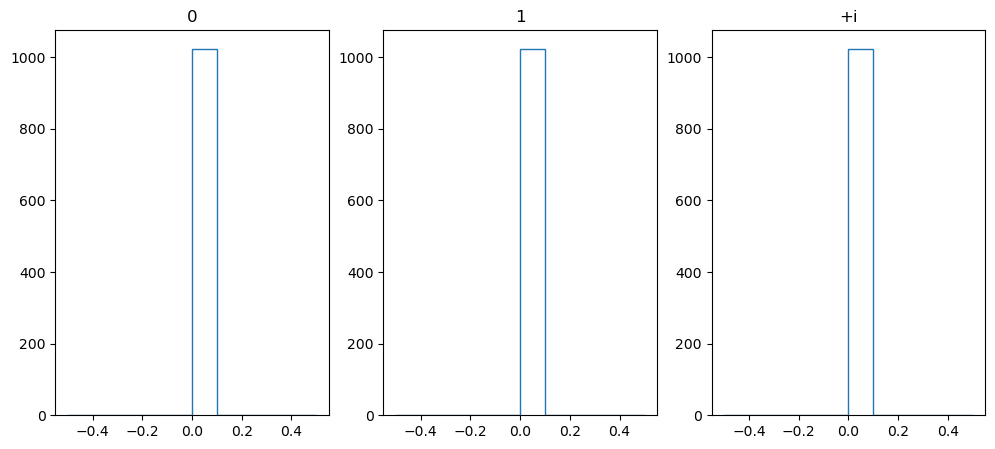

(<Figure size 1200x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '+i'}>], dtype=object))

In [23]:
coin_operator = XGate()

do_run(coin_operator, *standard_args)

No propagation! This is because the coin must superimpose for the walker to get superimposed. If no superposition, the propagator just repeatedly steps forwards and backwards on the same step.

In other words, the coin must have off-diagonals to walk at all.

Finally, let's try out the symmetric coin:

### $C_Y$ coin

$C_Y = \frac{1}{\sqrt{2}} \begin{pmatrix} 1 & i \\ i & 1 \end{pmatrix}$

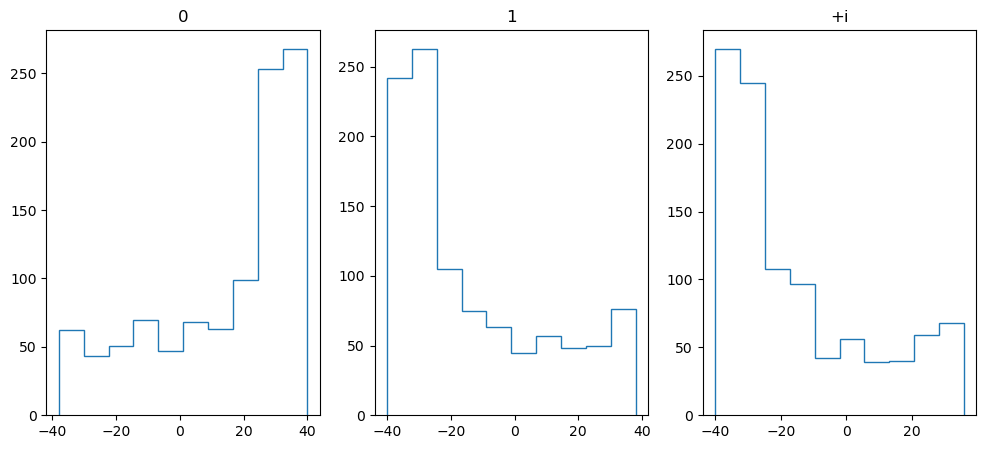

(<Figure size 1200x500 with 3 Axes>,
 array([<AxesSubplot: title={'center': '0'}>,
        <AxesSubplot: title={'center': '1'}>,
        <AxesSubplot: title={'center': '+i'}>], dtype=object))

In [24]:
CY_op = Operator( (1 / np.sqrt(2)) * np.array([
    [1, 1j],
    [1j, 1]
]))

CY = q.QuantumCircuit(1).unitary(CY_op, 0)

do_run(CY_op, *standard_args)

Unexpected. Why did we get asymmetric distributions when using $C_Y$? The StatevectorSimulator simulates the statevector deterministically, so noise is not an issue. 

A few reasons why:
1. Implementing arbitrary unitaries in Qiskit performs gate synthesis into discrete native gate-set. If no native decomposition exists, the unitary is approximated to certain error, $\varepsilon$. 
    BUT, maybe StatevectorSampler accepts arbitrary unitaries?
2. Other? 